CIFAR-10-CLASSIFCATION MODEL

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def unpickle(file): # - http://www.cs.toronto.edu/~kriz/cifar.html - this will open the file and return a dictionary 
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
dataset = unpickle("cifar-10-batches-py\data_batch_1") # loading data_batch_1 into the variable dataset
metadata = unpickle(r"cifar-10-batches-py\batches.meta") # These are the label names

Instead of importing the dataset directly, I decided to install it as a zip from online, to practice loading and wrangling the data

The website source of the dataset states:

 **data** -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

**labels** -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


In [5]:
print(dataset.keys(),
metadata.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames']) dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])


We can see the the relevant items in the dataset and metadata dictionary

In [6]:
labels = dataset[b'labels']
data = dataset[b'data']

In [7]:
len(data)
len(labels)

10000

As you can see, there are 10000 images + labels in our dataset. I will split the dataset in 80-20 training-testing into the following variables:

In [8]:
X_train = data[:8000]
X_test = data[8000:10000]

y_train = labels[:8000]
y_test = labels[8000:10000]

In [9]:
metadata.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [10]:
keys = metadata[b'label_names']
keys

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

a label of 0 should be a airplane, a label of 1 should be of a automobile

In [11]:
y_train[0]
# plt.imshow(X_train[0]) # This line throws a TypeError: Invalid shape (3072,) for image data. I realized, this is actually a 32 x 32 size image with RGB, however since there is nothing delimiting the rows
# So it just shows as 3072 - The images seem to have flattened, meaning I would need to "unflattern" them if I want to view them
# https://stackoverflow.com/questions/36967920/numpy-flatten-rgb-image-array 


6

In [12]:
test = X_train[0]

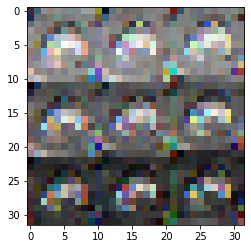

In [13]:
reshaped_image = test.reshape(32,32,3) # 32 x 32 (image size) with the 3 denoting the RGB values

plt.imshow(reshaped_image)


I'm going to have to reformat the array If I want to view the image, I will create a function that will allow me to view the image without changing the data structure of the original image

In [14]:
def show_image(index = 0, feature_data = X_train, label_data = y_train, keys = keys):
        """
        input feature, and label data, and the keys dictionary, optional param index

        displays the image + label
        """
        # The images are stored as a 3072 element vector, I need to reshape this into a tensor 
        # The image source states "The first 1024 bytes are the red channel values, the next 1024 the green,
        # and the final 1024 the blue. The values are stored in row-major order, so the first 32 bytes are the red channel values of the first row of the image."
        res = feature_data[index].reshape(3,32,32) 
        #matplotlib reads the RGB channels last in the matrix. So I'm rearranging the tensor accordingly
        res = np.transpose(res, axes=[1, 2, 0]) 

        plt.imshow(res)
        plt.title(keys[label_data[index]].decode("utf-8")) # adds the label; the decode removes the b and '' from the label for a pleasant viewing experience
        plt.axis('off') # I don't want the axis to show either
        plt.show()




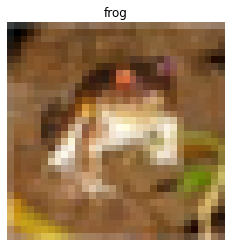

In [15]:
show_image()

Beautiful!

Creating model using keras

In [16]:
X_train, X_test = X_train / 255.0, X_test / 255.0
# since the values range from 1 to 256, I want them to range from 0-1, i will divide by 255 to achieve this. 
# Sources state this allows the model to perform more efficiently


In [17]:
model_v1 = tf.keras.Sequential([ # My model should have one input and one output tensor
    tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape = (3072,)), # input shape of 3072
    tf.keras.layers.Dense(128, activation=tf.nn.relu), # relu is a activation function, which determines the
    # output shape of each node in the layer
    tf.keras.layers.Dense(10) ])


    
# There is 2 layers with 2 nodes each, and a output layer with 10 nodes, each representing one of the 
# 10 possible categories


    

## Attempt 1
---

In this attempt, I decided to follow this [Walkthrough](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough) on the tensorflow website. 



This walkthrough involved defining your own loss and gradient functions. 

In [18]:
l = loss(model_v1, X_train, y_train, training=False)
print("Loss test: {}".format(l))

NameError: name 'loss' is not defined

In [ ]:
def grad(model,inputs,targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training = True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

Creating optimizer 



In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)
loss_value, grads = grad(model_v1, X_train, y_train)
print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model_v1.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model_v1, X_train, y_train, training=True).numpy()))

Step: 0, Initial Loss: 2.464334011077881
Step: 1,         Loss: 2.399326801300049


In [ ]:
model_v1.compile(loss = l, optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
model_v1.fit(X_train,y_train,batch_size=32)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

When trying to compile my model I run into this error

    ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

I think I can fix this by converting my datasets into numpy arrays


In [ ]:
X_train_v2 = np.array(X_train)
y_train_v2 = np.array(y_train)
X_test_v2 = np.array(X_test)
y_test_v2 = np.array(y_test)

l = loss(model_v1, X_train_v2, y_train_v2, training=False)

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)
loss_value, grads = grad(model_v1, X_train_v2, y_train_v2)
optimizer.apply_gradients(zip(grads, model_v1.trainable_variables))



<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [ ]:
model_v1.compile(loss = l, optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
model_v1.fit(X_train_v2,y_train_v2,batch_size=32)

ValueError: in user code:

    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 184, in __call__
        self.build(y_pred)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 133, in build
        self._losses = tf.nest.map_structure(self._get_loss_object, self._losses)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 272, in _get_loss_object
        loss = losses_mod.get(loss)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\losses.py", line 2372, in get
        raise ValueError(

    ValueError: Could not interpret loss function identifier: 2.362820863723755


Now I seem to get this error:

    ValueError: Could not interpret loss function identifier: 2.3097445964813232

I believe this is a problem with my custom loss function

In [ ]:
model_v1.compile(loss = 'SparseCategoricalCrossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
model_v1.fit(X_train_v2,y_train_v2,batch_size=32,epochs = 5, validation_split = 0.1)

Epoch 1/5
225/225 [==============================] - 2s 6ms/step - loss: 12.8475 - accuracy: 0.1032 - val_loss: 12.2801 - val_accuracy: 0.1175
Epoch 2/5
225/225 [==============================] - 1s 5ms/step - loss: 13.6690 - accuracy: 0.0985 - val_loss: 14.2625 - val_accuracy: 0.1150
Epoch 3/5
225/225 [==============================] - 1s 5ms/step - loss: 14.4630 - accuracy: 0.1022 - val_loss: 14.7279 - val_accuracy: 0.0862
Epoch 4/5
225/225 [==============================] - 1s 5ms/step - loss: 14.4682 - accuracy: 0.1024 - val_loss: 14.7279 - val_accuracy: 0.0862
Epoch 5/5
225/225 [==============================] - 1s 5ms/step - loss: 14.4682 - accuracy: 0.1024 - val_loss: 14.7279 - val_accuracy: 0.0862


The loss and accuracy are not changing between epochs, There seems to be a problem

In [ ]:
val_loss, val_acc = model_v1.evaluate(X_test_v2, y_test_v2)

63/63 [==============================] - 0s 3ms/step - loss: 14.5626 - accuracy: 0.0965


In [ ]:
predictions = model_v1.predict(X_test_v2)

63/63 [==============================] - 0s 2ms/step


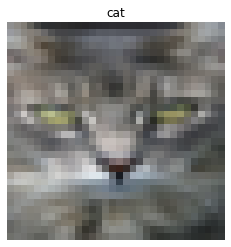

'deer'

In [ ]:
image = X_test_v2[0]
show_image(0, X_test, y_test)
keys[np.argmax(predictions[0])].decode("utf-8")



My model decided to predict this cat as a deer, it has a accuracy of 0.0990 and high high loss. My model guesses correctly 10 percent of the time, which should be expected with 10 outputs if you were to guess at random. My model doesn't work at all, it is completely broken. In hindsight I should not have tried to create my own loss function + optimiser, as I do not understand how it works. I will try again, to create a model using prebuilt loss and optimiser functions. I will focus on developing a accurate and working model.

## Attempt 2

---

Since data is already flattened, in the shape (3072,), I will not need to flatten the data. I will creating a model with the provided optimiser and loss functions.

In [ ]:
from tensorflow import keras #so I don't have to type tf. everytime

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(128, activation = 'relu'), # 128 neurons
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax') # Since there are 10 output classifications
    ])

In [ ]:
model.compile(optimizer = "adam",loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model.fit(X_train_v2,y_train_v2, epochs = 30)

Epoch 1/30
250/250 [==============================] - 2s 5ms/step - loss: 2.0888 - accuracy: 0.2271
Epoch 2/30
250/250 [==============================] - 1s 5ms/step - loss: 1.9004 - accuracy: 0.3043
Epoch 3/30
250/250 [==============================] - 1s 6ms/step - loss: 1.8157 - accuracy: 0.3478
Epoch 4/30
250/250 [==============================] - 1s 5ms/step - loss: 1.7653 - accuracy: 0.3646
Epoch 5/30
250/250 [==============================] - 1s 5ms/step - loss: 1.7057 - accuracy: 0.3836
Epoch 6/30
250/250 [==============================] - 1s 6ms/step - loss: 1.6716 - accuracy: 0.3950
Epoch 7/30
250/250 [==============================] - 1s 5ms/step - loss: 1.6429 - accuracy: 0.4025
Epoch 8/30
250/250 [==============================] - 1s 6ms/step - loss: 1.6124 - accuracy: 0.4176
Epoch 9/30
250/250 [==============================] - 1s 6ms/step - loss: 1.5676 - accuracy: 0.4375
Epoch 10/30
250/250 [==============================] - 2s 6ms/step - loss: 1.5492 - accuracy: 0.4392

In [ ]:
test_loss, test_acc = model.evaluate(X_test_v2,y_test_v2)

63/63 [==============================] - 0s 3ms/step - loss: 1.8911 - accuracy: 0.4070


This model with 30 epochs, has a accuracy of 0.7412, however when testing, the accuracy drops to 0.401
I think this means overfitting, My model seems to work properly this time, however it is not very reliable. I need to try and optimize it 

## Attempt 3

---

In this attempt, I will wrangle the data before feeding it to the model, using a modified show_image function, and include a extra flatten layer in my model

In [58]:
X_train_v3 = data[:8000]
X_test_v3 = data[8000:10000]

y_train_v3 = labels[:8000]
y_test_v3 = labels[8000:10000]

In [59]:
def convert_dataset(dataset):
        """
        input dataset
        converts the vector tensors inside the dataset into a eligible format

        returns a dataset with converted images.
        """
        res = [] 
        for i in range(len(dataset)):
                res.append(np.transpose(dataset[i].reshape(3,32,32), axes = [1,2,0]))
                
        return np.array(res)/255.0 # I had to convert the list into numpy array and divide all the elements by 255.0

    


In [60]:
X_train_v3 = convert_dataset(X_train_v3)
X_test_v3 = convert_dataset(X_test_v3)

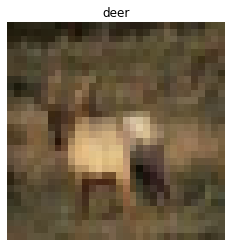

In [115]:
plt.imshow(X_train_v3[3])
plt.title(keys[y_train_v3[3]].decode("utf-8"))
plt.axis('off') 
plt.show()

My images seem to be legible

#### Creating the model

This model will be similar to the second attempt, with a extra flatten layer

In [91]:
import tensorflow as tf
from tensorflow import keras


In [93]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax') # Since there are 10 output classifications
    ])

In [108]:
model.compile(optimizer = "adam",loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [118]:
model.fit(X_train_v3,y_train_v3,batch_size= 32,epochs = 30)

Epoch 1/30
250/250 [==============================] - 1s 6ms/step - loss: 0.7520 - accuracy: 0.7343
Epoch 2/30
250/250 [==============================] - 1s 6ms/step - loss: 0.7586 - accuracy: 0.7299
Epoch 3/30
250/250 [==============================] - 1s 6ms/step - loss: 0.7705 - accuracy: 0.7206
Epoch 4/30
250/250 [==============================] - 1s 6ms/step - loss: 0.7545 - accuracy: 0.7268
Epoch 5/30
250/250 [==============================] - 1s 6ms/step - loss: 0.7501 - accuracy: 0.7303
Epoch 6/30
250/250 [==============================] - 1s 6ms/step - loss: 0.7438 - accuracy: 0.7289
Epoch 7/30
250/250 [==============================] - 1s 5ms/step - loss: 0.7165 - accuracy: 0.7429
Epoch 8/30
250/250 [==============================] - 1s 5ms/step - loss: 0.7282 - accuracy: 0.7344
Epoch 9/30
250/250 [==============================] - 2s 6ms/step - loss: 0.7112 - accuracy: 0.7400
Epoch 10/30
250/250 [==============================] - 1s 6ms/step - loss: 0.6871 - accuracy: 0.7535

In [120]:
test_loss, test_acc = model.evaluate(X_test_v3,y_test_v3)

63/63 [==============================] - 0s 4ms/step - loss: 2.9196 - accuracy: 0.4070


Feeding in (3,32,32) tensors as opposed to (3072,) seems to have no effect on the performance of the model. when evaluating the model. It still has the exact same accuracy of 0.407, and is overfitted with a accuracy of 0.7951

## Attempt 4